## Basic Storm Selection 

This notebook shows a presents a basic storm selection algorithm using OMNI data.

In [1]:
import numpy as npy
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib widget

In [2]:
def findSeq(X, thLo, thHi, thres=0, mlb=24*60):
    """
    iSel = findSeq(X, thLo, thHi,thres=0)
    Finds the indices of data that corresponds to the sequence crossing lower threshold thLo, then higher threshold thHi, and then thLo again. 
    Care should be taken when minima are required. Preceding peaks are included using maximum look back time mlb.

    Inputs
    ------
    X: data in numpy array format
    thLo: lower threshold
    thHi: high threshold
    thres: threshold for consecutive sequences to be joined, dependent on data sampling rate (default is 0, i.e. no joining unless already joined together)
    mlb: maximum look back time to find preceding peaks (default of 24 hours for 1 minute cadence data)
    
    Returns
    -------
    iSel: list of indices
    
    --2014/11/05 12:01-- sl
    --2023/01/18 16:00-- mh
    """

    print('Min / max thresholds are: %.2f , %.2f' % (thLo,thHi));

    # find where X < lower | X > high thresholds
    iLH = npy.where((X<thLo)|(X>thHi))[0];
    x02 = npy.zeros_like(iLH);

    # test if any are found
    iThHi = npy.where(X[iLH] > thHi)[0];
    if len(iThHi)==0:
        print('No sequences found. Returning [].');
        return [];

    x02[iThHi] = 2;

    # use diff to find changes between high and low
    xxx = npy.diff(x02);
    iOp = iLH[npy.where(xxx==2)[0]];
    iAf = iLH[npy.where(xxx==-2)[0]+1];
    
    # Look back MLB steps from beginning of sequence and find the minimum, then go back another MLB/2 steps. This is to catch the SSC.
    iOp2 = iOp.copy();
    for i in range(0,len(iOp)):
        iOp2[i] = npy.argmin(X[(iOp[i]-mlb):iOp[i]]) + iOp[i]-mlb - mlb/2;
        iOp = iOp2;
        # if we begin high, then go from beginning
        if iAf[0] < iOp[0]:
            iOp = npy.array([0] + list(iOp),dtype=int);
            N = len(X);
            # if we end high, go to the end
            if iAf[-1:] < iOp[-1:]:
                iAf = npy.array(list(iAf) + [N],dtype=int);

    if len(iOp)!=len(iAf): 
        print('Error: sequence start and end points do not match.')
    else:
        print('%d sequences found.' % (len(iOp)));

    # create array with all selected indices
    iSel = [];
    flag = False
    for i in range(0,len(iOp)):
        if flag==True:
            flag=False
            continue
        if i<len(iOp)-1:
            if iOp[i+1]-iAf[i]<thres:
                print('Joining two sequences next to each other (within the threshold).')
                iSel.append(range(iOp[i],iAf[i+1]));
                flag = True
            else:
                iSel.append(range(iOp[i],iAf[i]));
        else:
            iSel.append(range(iOp[i],iAf[i]));
        iSel = list(itertools.chain.from_iterable(npy.asarray(a).ravel() for a in iSel))
        
    return iSel

In [3]:
dat=pd.read_csv('c:\\Users\\mikeh\\Downloads\\symh.txt',skiprows=13,header=1,delim_whitespace=True,parse_dates=[['DATE', 'TIME']],index_col=0)
dat

,DOY,ASY-D,ASY-H,SYM-D,SYM-H
DATE_TIME,,,,,
2003-01-01 00:00:00,1,21.0,16.0,-2.0,-6.0
2003-01-01 00:01:00,1,20.0,16.0,-2.0,-5.0
2003-01-01 00:02:00,1,20.0,16.0,-2.0,-5.0
2003-01-01 00:03:00,1,20.0,17.0,-2.0,-5.0
2003-01-01 00:04:00,1,20.0,17.0,-2.0,-5.0
...,...,...,...,...,...
2003-12-31 23:55:00,365,10.0,15.0,-2.0,-23.0
2003-12-31 23:56:00,365,10.0,15.0,-2.0,-24.0
2003-12-31 23:57:00,365,10.0,15.0,-2.0,-23.0


In [4]:
inds=findSeq(-dat['SYM-H'],20,100,6*60)

Min / max thresholds are: 20.00 , 100.00
9 sequences found.
Joining two sequences next to each other (within the threshold).


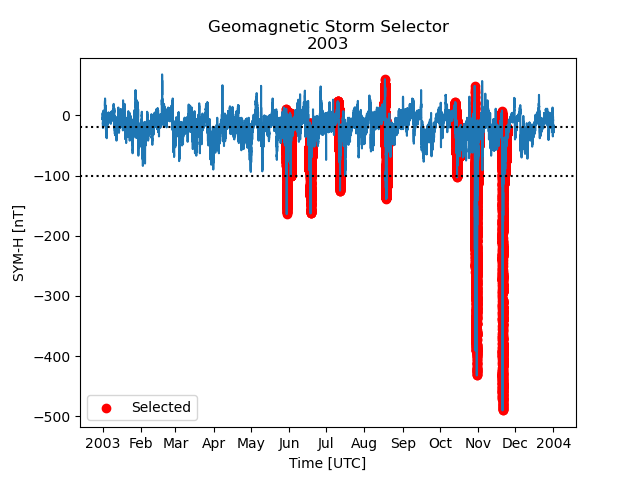

In [5]:
plt.figure()
plt.plot(dat['SYM-H'])
plt.scatter(dat.iloc[inds].index,dat['SYM-H'].iloc[inds],color='r',label='Selected')
plt.axhline(-20,color='k',linestyle=':')
plt.axhline(-100,color='k',linestyle=':')
plt.title('Geomagnetic Storm Selector\n2003')
plt.xlabel('Time [UTC]')
plt.ylabel('SYM-H [nT]')
locator = mdates.AutoDateLocator(minticks=12, maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend()
plt.show()